In [1]:
import numpy as np
from scipy.signal import StateSpace, lsim
import matplotlib.pyplot as plt
from numpy import linalg as LA
import cvxpy as cp
import dill

In [2]:
#dill.load_session('notebook_env.db')       #Uncomment it to load previous session

In [3]:
p=0.2
q=0.3
M=np.matrix([[p,1-p],[1-q,q]])


infeasibility_flag=0


In [4]:
# We write a function to compute ridge regression for matrices for system parameter estimation

def square_matrix_ridge_regression(X,Y,Astar,lmda,beeta):
    t=1+X.shape[1]
    D=lmda*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    C=lmda*Astar
    for s in range(1,t):
        xs=X[:,s-1]
        ys=Y[:,s-1]
        C=C+(1/beeta)*np.outer(ys,xs)
        D=D+(1/beeta)*np.outer(xs,xs)
    return C.dot(np.linalg.inv(D))

In [5]:
# A function for the big dot

def big_dot(A,B):
    return np.trace(np.dot(A.T,B))


In [6]:
# Function for the SDP solver

def SDP_solver(At,Bt,Vt,W,mu):
    Vtinv=np.linalg.inv(Vt)
    Sigma=cp.Variable((n,n))
    sxx=cp.Variable((2,2))
    suu=cp.Variable((2,2))
    constraints=[Sigma>>0]
    bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
    ABt=np.column_stack((At,Bt))
    #Cost_Coefficient=np.array([[Q,[[1,0],[0,1]]],[[[1,0],[0,1]],R]])
    I=np.array([[1,0],[0,1]])
    
    Left=np.array([[1,0,0,0],[0,1,0,0]])
    Right=np.array([[1,0],[0,1],[0,0],[0,0]])
    
    constraints+=[ sxx  >> (((ABt)@Sigma)@(ABt.T))+W-mu*cp.trace((Sigma.T)@(Vtinv))*I ]
    
    constraints+=[ sxx == (Left@Sigma)@Right  ]
    
    Lefty=np.array([[0,0,1,0],[0,0,0,1]])
    Righty=np.array([[0,0],[0,0],[1,0],[0,1]])
    
    constraints+=[ suu == (Lefty@Sigma)@Righty  ]
    
    prob = cp.Problem(cp.Minimize(cp.trace(sxx.T @ Q + suu.T @ R)),constraints)
    prob.solve()
    if(Sigma.value is None):
        infeasibility_flag=1
        print(prob.value)
        print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (bigI)
    else:
        infeasibility_flag=0
    
        #print("Infeasibilty_flag value is: ",infeasibility_flag)
        return (Sigma.value)


In [7]:
a=np.random.rand(2)
b=np.random.rand(2)
a,b

(array([0.22323657, 0.99045201]), array([0.39731452, 0.11762461]))

In [8]:
Q=np.outer(a,a)
R=np.outer(b,b)


pd1=0.5*np.random.rand(1)
pd2=0.5*np.random.rand(1)

I=np.array([[1,0],[0,1]])

Q=Q+pd1*I
R=R+pd2*I

mode_difference_std_dev=0.5

In [9]:
A1=np.random.rand(2,2)
B1=np.random.rand(2,2)
A2=A1+np.random.normal(0,mode_difference_std_dev,A1.shape)
B2=B1+np.random.normal(0,mode_difference_std_dev,B1.shape)
#var1=0.01*np.random.rand(1)  Original
#var2=0.01*np.random.rand(1)  Original
var1=0.001*np.random.rand(1)  #Trying low noise
var2=0.001*np.random.rand(1)  #TRying low noise
K=np.random.rand(2,2)



#scale=0.1

scale1=0.1
scale2=0.1
K=scale1*K
A1=scale1*A1
A2=scale2*A2
B1=scale1*B1
B2=scale2*B2
var1=scale1*scale1*var1
var2=scale2*scale2*var2


In [10]:
LA.norm(A1+B1.dot(K),2)


0.09159062583209777

In [11]:
LA.norm(A2+B2.dot(K),2)

0.0733698662726976

In [12]:
time=np.arange(0,3000,1e-3)
time.shape
cost=np.zeros((time.shape[0]))
x_norm=np.zeros((time.shape[0]))

In [13]:
#Here we run the previous Riccati to empirically find a safe nu, note we use a random policy K instead of the Riccati
# equation based optimal policy to get a safe upper bound and find all the hyperparameters for both modes a and b.



#Starting Mode a

x_dynamicsa=np.zeros((2,time.shape[0]))
x_0a=np.random.rand(2)
x_dynamicsa[:,0]=x_0a


u_0a=K.dot(x_0a)

costa=np.zeros((time.shape[0]))
x_norma=np.zeros((time.shape[0]))

c_0a=x_0a.dot((Q.dot(x_0a)))+u_0a.dot((R.dot(u_0a)))

costa[0]=c_0a
x_norma[0]=LA.norm(x_0a,2)

for t in range(1,time.shape[0]):
    xprev=x_dynamicsa[:,t-1]
    uprev=K.dot(xprev)
    xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(costa[t-1]*(t)+ct)/(t+1)
    x_norma[t]=LA.norm(xt,2)
    costa[t]=c
    x_dynamicsa[:,t]=xt
    
Final_Costa=(costa[time.shape[0]-1]*(time.shape[0])+x_dynamicsa[:,time.shape[0]-1].dot(Q.dot(x_dynamicsa[:,time.shape[0]-1])))/(time.shape[0]+1)

Final_Costa_agg=Final_Costa*(time.shape[0]+1)

print(Final_Costa)

print(Final_Costa_agg)


3.1286182648143787e-06
9.385857923061401


In [14]:
#Now for Mode b

x_dynamicsb=np.zeros((2,time.shape[0]))
x_0b=np.random.rand(2)
x_dynamicsb[:,0]=x_0b


u_0b=K.dot(x_0b)

costb=np.zeros((time.shape[0]))
x_normb=np.zeros((time.shape[0]))

c_0b=x_0b.dot((Q.dot(x_0b)))+u_0b.dot((R.dot(u_0b)))

costb[0]=c_0b
x_normb[0]=LA.norm(x_0b,2)

for t in range(1,time.shape[0]):
    xprev=x_dynamicsb[:,t-1]
    uprev=K.dot(xprev)
    xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,np.sqrt(var2),xprev.shape)
    ut=K.dot(xt)
    ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(costb[t-1]*(t)+ct)/(t+1)
    x_normb[t]=LA.norm(xt,2)
    costb[t]=c
    x_dynamicsb[:,t]=xt
    
Final_Costb=(costb[time.shape[0]-1]*(time.shape[0])+x_dynamicsb[:,time.shape[0]-1].dot(Q.dot(x_dynamicsb[:,time.shape[0]-1])))/(time.shape[0]+1)

Final_Costb_agg=Final_Costb*(time.shape[0]+1)

print(Final_Costb)

print(Final_Costb_agg)


6.644989025404693e-06
19.934973721203104


In [15]:
print(costa[time.shape[0]-1])

3.128618358577354e-06


In [16]:
print(costb[time.shape[0]-1])

6.6449910441997855e-06


In [17]:
noise_sample=np.random.normal(0,np.sqrt(var2),xprev.shape)
print(noise_sample)

control_noise_sample=K.dot(noise_sample)

cost_noise=noise_sample.dot(Q.dot(noise_sample))+control_noise_sample.dot(R.dot(control_noise_sample))
print(cost_noise)

[ 0.00075093 -0.00140748]
1.872177295670858e-06


In [18]:
x_normb[0]

0.7800494845831847

In [19]:
#Now we set the hyperparameters for the OSLO Algorithm, alpha0 and alpha1 are same for both modes.


n=4 #n=k+d=2+2=4

delta=0.1

q1,q2=LA.eigh(Q)
r1,r2=LA.eigh(R)


minq=np.amin(q1)
maxq=np.amax(q1)
minr=np.amin(r1)
maxr=np.amax(r1)



alpha0=min(minq,minr)

alpha1=max(maxq,maxr)

Augmenteda=np.column_stack((A1,B1))

nua=0.0005  #Experimental value from repeatedly upper bounding last to last cell

          #based on the above experiment running the previous block several times, the average cost on convergence is

         # always upper bounded by the value of nu chosen so J* is definitely upper bounded by it 

vhia=LA.norm(Augmenteda,2)





Augmentedb=np.column_stack((A2,B2))

nub=0.0005  #Experimental value from repeatedly upper bounding last cell

          #based on the above experiment running the previous block several times, the average cost on convergence is

         # always upper bounded by the value of nu chosen so J* is definitely upper bounded by it 

vhib=LA.norm(Augmentedb,2)



In [20]:
#Line 2 of the algorithm; initializing parameters

mua=5*vhia*np.sqrt(time.shape[0])


lamdaa=(2048*np.power(nua,5)*vhia*np.sqrt(time.shape[0]))/(np.power(alpha0,5)*np.power(var1,5))

betaa=(256*1024*np.power(nua,4)*n*n*np.log((time.shape[0])/delta))/(np.power(alpha0,4)*np.power(var1,3))

bigI=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])


#Manually setting lamda and beta

lamdaa=1000000

betaa=0.0000001

#Try beta = 1 and lamda=0.01,0.1 both

#manual setting done


V1a=lamdaa*bigI



print(mua,lamdaa,betaa)

print(V1a)


#The other mode

mub=5*vhib*np.sqrt(time.shape[0])

lamdab=(2048*np.power(nub,5)*vhib*np.sqrt(time.shape[0]))/(np.power(alpha0,5)*np.power(var2,5))

betab=(256*1024*np.power(nub,4)*n*n*np.log((time.shape[0])/delta))/(np.power(alpha0,4)*np.power(var2,3))



#Manually setting lamda and beta

lamdab=1000000

betab=0.0000001

#manual setting done


V1b=lamdab*np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])



print(mub,lamdab,betab)

print(V1b)





1058.0056970245778 1000000 1e-07
[[1000000       0       0       0]
 [      0 1000000       0       0]
 [      0       0 1000000       0]
 [      0       0       0 1000000]]
1707.1023229898992 1000000 1e-07
[[1000000       0       0       0]
 [      0 1000000       0       0]
 [      0       0 1000000       0]
 [      0       0       0 1000000]]


In [21]:
# We set further parameters for input of the algorithm (1st line in the paper)


delta=0.1

epsilona=1/(4*lamdaa)

epsa=0.007 #Manually chosen epsilon

A0a=A1+np.sqrt(epsa/n)*np.random.rand(2,2)

B0a=B1+np.sqrt(epsa/n)*np.random.rand(2,2)

Wa=var1*I

epsilonb=1/(4*lamdab)

epsb=0.007 #Manually chosen epsilon

A0b=A2+np.sqrt(epsb/n)*np.random.rand(2,2)

B0b=B2+np.sqrt(epsb/n)*np.random.rand(2,2)

Wb=var2*I



In [22]:
#Now we prepare to run the dynamical system with policies as dictated by OSLO algorithm

x_dynamics=np.zeros((2,time.shape[0]+1))
z_dynamics=np.zeros((4,time.shape[0]+1))
x_0=(0.1)*np.random.rand(2)
x_dynamics[:,0]=x_0
z_dynamics[0:2,0]=x_0

#Now we assume the system begins at mode a

acount=1
bcount=0

#K0=np.random.rand(2,2)
#u_0=K0.dot(x_0)
#z_dynamics[2:4,0]=u_0




x_dynamicsa=np.zeros((2,time.shape[0]+1))
z_dynamicsa=np.zeros((4,time.shape[0]+1))

x_dynamicsb=np.zeros((2,time.shape[0]+1))
z_dynamicsb=np.zeros((4,time.shape[0]+1))

x_dynamicsa[:,0]=x_0
z_dynamicsa[0:2,0]=x_0

#z_dynamicsb[0:2,0]=x_0
#z_dynamicsa[2:4,0]=u_0








A_dynamicsa=np.zeros((time.shape[0]+1,2,2))
B_dynamicsa=np.zeros((time.shape[0]+1,2,2))
K_dynamicsa=np.zeros((time.shape[0]+1,2,2))

A_dynamicsa[0]=A0a
B_dynamicsa[0]=B0a
#K_dynamicsa[0]=K0

V_dynamicsa=np.zeros((time.shape[0]+1,4,4))
V_dynamicsa[0]=V1a

Sigma_0a=SDP_solver(A_dynamicsa[0],B_dynamicsa[0],V_dynamicsa[0],Wa,mua)

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])

#Do this correction while running as well, for policy computation take sigma_xx first and then take its inverse


Sigma_0_xx=(Left.dot(Sigma_0a)).dot(Right)
Sigma_0_xx_inv=np.linalg.inv(Sigma_0_xx)
K0a=(Sigma_0a[2:4,0:2]).dot((Sigma_0_xx_inv))

K_dynamicsa[0]=K0a

u_0=K0a.dot(x_0)
z_dynamicsa[2:4,0]=u_0








cost=np.zeros((time.shape[0]+1))
agg_cost_dynamics=np.zeros((time.shape[0]+1))
z_norm=np.zeros((time.shape[0]+1))
x_norm=np.zeros((time.shape[0]+1))
c_0=x_0.dot((Q.dot(x_0)))+u_0.dot((R.dot(u_0)))


cost[0]=c_0
agg_cost_dynamics[0]=c_0

x_1=A1.dot(x_0)+B1.dot(u_0)+np.random.normal(0,np.sqrt(var1),x_0.shape)

z_norm[0]=LA.norm(z_dynamicsa[:,0],2)
x_norm[0]=LA.norm(x_0,2)

x_dynamicsa[:,1]=x_1

x_norm[1]=LA.norm(x_1,2)


z0=z_dynamicsa[:,0]

z_dynamics[:,0]=z0
x_dynamics[:,1]=x_1

V_dynamicsa[1]=V_dynamicsa[0]+(1/betaa)*np.outer(z0,z0)

#Episode index is tau, and we need to start an episode at the beginning

taua=0

#Now all the intializations are done for mode a, so we repeat the same for mode b



A_dynamicsb=np.zeros((time.shape[0]+1,2,2))
B_dynamicsb=np.zeros((time.shape[0]+1,2,2))
K_dynamicsb=np.zeros((time.shape[0]+1,2,2))

A_dynamicsb[0]=A0b
B_dynamicsb[0]=B0b
#K_dynamicsb[0]=K0a #We need this policy to run when mode B is encountered first it just needs to be any policy(??)

V_dynamicsb=np.zeros((time.shape[0]+1,4,4))
V_dynamicsb[0]=V1b



Sigma_0b=SDP_solver(A_dynamicsb[0],B_dynamicsb[0],V_dynamicsb[0],Wb,mub)

Left=np.array([[1,0,0,0],[0,1,0,0]])
Right=np.array([[1,0],[0,1],[0,0],[0,0]])

#Do this correction while running as well, for policy computation take sigma_xx first and then take its inverse


Sigma_0_xx=(Left.dot(Sigma_0b)).dot(Right)
Sigma_0_xx_inv=np.linalg.inv(Sigma_0_xx)
K0b=(Sigma_0b[2:4,0:2]).dot((Sigma_0_xx_inv))

K_dynamicsb[0]=K0b

#u_0=K0b.dot(x_0)
#z_dynamicsb[2:4,0]=u_0
#z_dynamicsb[0:2,0]=x_0


#z0=z_dynamicsb[:,0]



#V_dynamicsb[1]=V_dynamicsb[0]+(1/betab)*np.outer(z0,z0)


#V_dynamicsb[1]=V_dynamicsb[0]



#V_dynamicsb[1]=V_dynamicsb[0]+(1/betab)*np.outer(z0,z0)

#Episode index is tau, and we need to start an episode at the beginning

taub=0



WARN: m less than n, problem likely degenerate
WARN: m less than n, problem likely degenerate


In [23]:
#Next we implement the modified OSLO here


markov_state=0
ms=np.zeros((time.shape[0]))
ms[0]=0

#noise1=np.array([[var1,0],[0,var1]])

#noise2=np.array([[var2,0],[0,var2]])

for t in range(1,time.shape[0]):
    
    markov_state=ms[t-1]
    if (markov_state==0):
        markov_state=np.random.choice(2,1,p=[p,1-p])
        ms[t]=markov_state
    else:
        markov_state=np.random.choice(2,1,p=[1-q,q])
        ms[t]=markov_state
        

        
    
    
    #The big else from OSLO should be nested within the if else for Markov State here:

    if (markov_state==0):
        
        if (np.linalg.det(V_dynamicsa[acount])>2*np.linalg.det(V_dynamicsa[taua])):
            taua=acount 
            #starts a new episode in this case and estimate parameters for this episode next
            X=x_dynamicsa[:,1:acount]
            Z=z_dynamicsa[:,0:acount-1]
            A0B0=np.column_stack((A0a,B0a))
            AtBt=square_matrix_ridge_regression(Z,X,A0B0,lamdaa,betaa)
            A_dynamicsa[acount]=AtBt[:,0:2]
            B_dynamicsa[acount]=AtBt[:,2:4]

            #Now we compute the policy for this round using SDP solver


            Sigmat=SDP_solver(A_dynamicsa[acount],B_dynamicsa[acount],V_dynamicsa[acount],Wa,mua)
            
            
            if (infeasibility_flag == 1):
                #A_dynamicsa[acount]=A_dynamicsa[acount-1]
                #B_dynamicsa[acount]=B_dynamicsa[acount-1]
                K_dynamicsa[t]=K_dynamicsa[t-1]
                K_dynamicsb[t]=K_dynamicsb[t-1]
                
                print(taua)
                print(Sigmat)
                
        
            else:
                print(taua)
                print('a')
                #print(Sigmat)
            
            #Extracting policy from the relaxed SDP's solution
            
                Left=np.array([[1,0,0,0],[0,1,0,0]])
                Right=np.array([[1,0],[0,1],[0,0],[0,0]])
            
                Sigma_t_xx=(Left.dot(Sigmat)).dot(Right)
                Sigma_t_xx_inv=np.linalg.inv(Sigma_t_xx)
                Kt=(Sigmat[2:4,0:2]).dot((Sigma_t_xx_inv))
                K_dynamicsa[t]=Kt
                K_dynamicsb[t]=K_dynamicsb[t-1]
                print(K_dynamicsa[t])
                
        


        else:
            A_dynamicsa[acount]=A_dynamicsa[acount-1]
            B_dynamicsa[acount]=B_dynamicsa[acount-1]
            K_dynamicsa[t]=K_dynamicsa[t-1]
            K_dynamicsb[t]=K_dynamicsb[t-1]   ##Doubtful line
                
   
        
    
    
    
    
        #Policy computed
        #Now we update the parameters for the next round: part of the OSLO
        ut=K_dynamicsa[t].dot(x_dynamics[:,t])
        
        x_dynamics[:,t+1]=A1.dot(x_dynamics[:,t])+B1.dot(ut)+np.random.normal(0,np.sqrt(var1),x_dynamics[:,t].shape)
        acount=acount+1
        x_dynamicsa[:,acount]=x_dynamics[:,t+1]
        
        
        zt=np.zeros(4)
        zt[0:2]=x_dynamics[:,t]
        zt[2:4]=ut
        xt=x_dynamics[:,t]
        z_dynamics[:,t]=zt
        z_dynamicsa[:,acount-1]=zt
        z_norm[t]=LA.norm(zt,2)
        V_dynamicsa[acount]=V_dynamicsa[acount-1]+(1/betaa)*np.outer(zt,zt)
        # Change to OSLO ends here
        ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
        c=(cost[t-1]*(t)+ct)/(t+1)
        x_norm[t+1]=LA.norm(x_dynamics[:,t+1],2)
        cost[t]=c
        agg_cost_dynamics[t]=agg_cost_dynamics[t-1]+ct
        
        
        
        
        
        
        
        
    else:
        
        if(bcount==0):
            x_dynamicsb[:,bcount]=x_dynamics[:,t]
        
        bcount=bcount+1
        
        
        if (np.linalg.det(V_dynamicsb[bcount-1])>2*np.linalg.det(V_dynamicsb[taub])):
            taub=bcount-1 
            #starts a new episode in this case and estimate parameters for this episode next
            X=x_dynamicsb[:,1:bcount]
            Z=z_dynamicsb[:,0:bcount-1]
            A0B0=np.column_stack((A0b,B0b))
            AtBt=square_matrix_ridge_regression(Z,X,A0B0,lamdab,betab)
            A_dynamicsb[bcount]=AtBt[:,0:2]
            B_dynamicsb[bcount]=AtBt[:,2:4]

            #Now we compute the policy for this round using SDP solver


            Sigmat=SDP_solver(A_dynamicsb[bcount],B_dynamicsb[bcount],V_dynamicsb[bcount-1],Wb,mub)
            
            
            if (infeasibility_flag == 1):
                #A_dynamicsb[t]=A_dynamicsb[t-1]
                #B_dynamicsb[t]=B_dynamicsb[t-1]
                K_dynamicsb[t]=K_dynamicsb[t-1]
                K_dynamicsa[t]=K_dynamicsa[t-1]
                print(taub)
                print(Sigmat)
        
            else:
                print(taub)
                print('b')
                #print(Sigmat)
            
            #Extracting policy from the relaxed SDP's solution
            
                Left=np.array([[1,0,0,0],[0,1,0,0]])
                Right=np.array([[1,0],[0,1],[0,0],[0,0]])
            
                Sigma_t_xx=(Left.dot(Sigmat)).dot(Right)
                Sigma_t_xx_inv=np.linalg.inv(Sigma_t_xx)
                Kt=(Sigmat[2:4,0:2]).dot((Sigma_t_xx_inv))
                K_dynamicsb[t]=Kt
                K_dynamicsa[t]=K_dynamicsa[t-1]
                print(K_dynamicsb[t])

                
        else:
            A_dynamicsb[bcount]=A_dynamicsb[bcount-1]
            B_dynamicsb[bcount]=B_dynamicsb[bcount-1]
            K_dynamicsb[t]=K_dynamicsb[t-1]
            K_dynamicsa[t]=K_dynamicsa[t-1]
   
        
    
    
    
    
        #Policy computed
        #Now we update the parameters for the next round: part of the OSLO
        xt=x_dynamics[:,t]
        ut=K_dynamicsb[t].dot(xt)
        
        #Play this policy
        
        x_dynamics[:,t+1]=A2.dot(x_dynamics[:,t])+B2.dot(ut)+np.random.normal(0,np.sqrt(var2),x_dynamics[:,t].shape)
        
        x_dynamicsb[:,bcount]=x_dynamics[:,t+1]
        
        
        
        zt=np.zeros(4)
        zt[0:2]=xt
        zt[2:4]=ut
        z_dynamics[:,t]=zt
        z_dynamicsb[:,bcount-1]=zt
        z_norm[t]=LA.norm(zt,2)
        V_dynamicsb[bcount]=V_dynamicsb[bcount-1]+(1/betab)*np.outer(zt,zt)
        # Change to OSLO ends here
        ct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
        c=(cost[t-1]*(t)+ct)/(t+1)
        x_norm[t+1]=LA.norm(x_dynamics[:,t+1],2)
        cost[t]=c
        agg_cost_dynamics[t]=agg_cost_dynamics[t-1]+ct

        
Final_Cost=(cost[time.shape[0]-1]*(time.shape[0])+x_dynamics[:,time.shape[0]].dot(Q.dot(x_dynamics[:,time.shape[0]])))/(time.shape[0]+1)
        
Final_Cost_agg=Final_Cost*(time.shape[0]+1)      
        
        
        
        
        









WARN: m less than n, problem likely degenerate
9082
a
[[-0.01033147 -0.00430267]
 [-0.02342626 -0.01043816]]
WARN: m less than n, problem likely degenerate
14507
b
[[-0.00480069 -0.00877627]
 [-0.00649979 -0.01069113]]
WARN: m less than n, problem likely degenerate
22684
a
[[-0.00995674 -0.00331842]
 [-0.02264001 -0.00823408]]
WARN: m less than n, problem likely degenerate
35140
b
[[-0.00344089 -0.00676545]
 [-0.00478195 -0.0080979 ]]
WARN: m less than n, problem likely degenerate
42025
a
[[-0.0093847  -0.00303636]
 [-0.02126871 -0.00749695]]
WARN: m less than n, problem likely degenerate
64116
b
[[-0.00288614 -0.00554681]
 [-0.0040693  -0.00651232]]
WARN: m less than n, problem likely degenerate
69568
a
[[-0.0092891  -0.00311034]
 [-0.02088113 -0.00755962]]
WARN: m less than n, problem likely degenerate
104975
b
[[-0.00362126 -0.00486386]
 [-0.00500901 -0.00565862]]
WARN: m less than n, problem likely degenerate
108170
a
[[-0.0093833  -0.00291547]
 [-0.02106516 -0.00724959]]
WARN: m l

In [24]:
#Testing convergence of parameter estimation for mode a:
#print(LA.norm((Augmented-AtBt),'fro'))
erra=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsa[t],B_dynamicsa[t]))
    erra[t]=LA.norm((Augmenteda-AtBt),'fro')
    
#plt.plot(time[0:time.shape[0]],erra[0:time.shape[0]])

In [25]:
#Testing convergence of parameter estimation for mode b:
#print(LA.norm((Augmented-AtBt),'fro'))
errb=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    AtBt=np.column_stack((A_dynamicsb[t],B_dynamicsb[t]))
    errb[t]=LA.norm((Augmentedb-AtBt),'fro')
    
#plt.plot(time[10:time.shape[0]],errb[10:time.shape[0]])

In [26]:
Final_Cost

4.632892279092641e-06

In [27]:
Final_Cost_agg

13.898681470170201

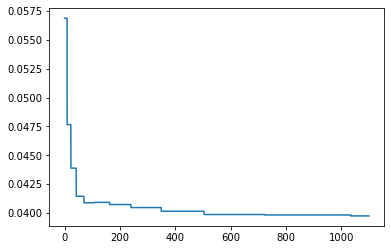

In [28]:
plt.plot(time[0:1100000],erra[0:1100000])

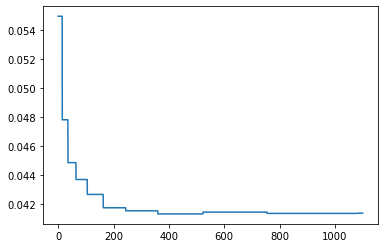

In [29]:
plt.plot(time[0:1100000],errb[0:1100000])

In [30]:
#Now we compare against the benchmark from Vijay Gupta's extension of the Riccati Equations based Optimal Policy


#Ricatti Solver and testing the average cost with this

Opt_x_dynamics=np.zeros((2,time.shape[0]))
Opt_x_0=np.random.rand(2)
Opt_x_dynamics[:,0]=Opt_x_0
Opt_x_dynamics
Opt_cost=np.zeros((time.shape[0]))
Opt_cost_agg=np.zeros((time.shape[0]))
Opt_x_norm=np.zeros((time.shape[0]))



# Dynamic Programming for Riccati Solver Policies as in Vijay Gupta's MJLS notes: http://www.cds.caltech.edu/~murray/books/AM08/pdf/ncs-markjls_22Jan10.pdf


P1=np.zeros((time.shape[0],2,2))
K1=np.zeros((time.shape[0],2,2))
P2=np.zeros((time.shape[0],2,2))
K2=np.zeros((time.shape[0],2,2))
#zero_init=np.zeros((2,2))
for t in range((time.shape[0])):
    P1[t]=np.zeros((2,2))
    P2[t]=np.zeros((2,2))
    K1[t]=np.zeros((2,2))
    K2[t]=np.zeros((2,2))
P1[time.shape[0]-1]=Q
P2[time.shape[0]-1]=Q
K1[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,Q),B1)),B1.T),Q),A1)
K2[time.shape[0]-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,Q),B2)),B2.T),Q),A2)

for t in range(1,time.shape[0]):
    P1[time.shape[0]-t-1]=p*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+(1-p)*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    P2[time.shape[0]-t-1]=(1-q)*(Q+np.dot(A1.T,np.dot(P1[time.shape[0]-t],A1))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A1.T,P1[time.shape[0]-t].T),B1),np.linalg.inv(R+np.dot(B1.T,np.dot(P1[time.shape[0]-t],B1)))),B1.T),P1[time.shape[0]-t]),A1))+q*(Q+np.dot(A2.T,np.dot(P2[time.shape[0]-t],A2))-np.dot(np.dot(np.dot(np.dot(np.dot(np.dot(A2.T,P2[time.shape[0]-t].T),B2),np.linalg.inv(R+np.dot(B2.T,np.dot(P2[time.shape[0]-t],B2)))),B2.T),P2[time.shape[0]-t]),A2))
    K1[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B1.T,P1[time.shape[0]-t]),B1)),B1.T),P1[time.shape[0]-t]),A1)
    K2[time.shape[0]-t-1]=np.dot(np.dot(np.dot(np.linalg.inv(R+np.dot(np.dot(B2.T,P1[time.shape[0]-t]),B2)),B2.T),P2[time.shape[0]-t]),A2)













In [31]:
#Now we run the Riccati Optimal Policies

#First some initializations

markov_state=0
Opt_ms=np.zeros((time.shape[0]))
Opt_ms[0]=0

Opt_u_0= -K1[0].dot(Opt_x_0)

Opt_c_0=Opt_x_0.dot((Q.dot(Opt_x_0)))+Opt_u_0.dot((R.dot(Opt_u_0)))

Opt_cost[0]=Opt_c_0
Opt_cost_agg[0]=Opt_c_0
Opt_x_norm[0]=LA.norm(Opt_x_0,2)

#Now we simulate the Markov Jump Dynamical System, this time playing optimally using Riccati Policies

for t in range(1,time.shape[0]):
    xprev=Opt_x_dynamics[:,t-1]
    markov_state=Opt_ms[t-1]
    if (markov_state==0):
        uprev=-K1[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[p,1-p])
    else:
        uprev=-K2[t-1].dot(xprev)
        markov_state=np.random.choice(2,1,p=[1-q,q])    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
        ut=-K1[t].dot(xt)
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,np.sqrt(var2),xprev.shape)
        ut=-K2[t].dot(xt)
    nct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(Opt_cost[t-1]*(t)+nct)/(t+1)
    Opt_x_norm[t]=LA.norm(xt,2)
    Opt_cost[t]=c
    Opt_cost_agg[t]=Opt_cost_agg[t-1]+nct
    Opt_ms[t]=markov_state
    Opt_x_dynamics[:,t]=xt

Opt_Final_Cost=(Opt_cost[time.shape[0]-1]*(time.shape[0])+Opt_x_dynamics[:,time.shape[0]-1].dot(Q.dot(Opt_x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)

Opt_Final_Cost_agg=Opt_Final_Cost*(time.shape[0]+1)


In [61]:
-K1[1000000]

array([[-0.00410944, -0.00120208],
       [-0.0108745 , -0.00371273]])

In [62]:
-K2[1000000]

array([[-0.00383858, -0.00265361],
       [-0.00467267, -0.0002526 ]])

In [63]:
K_dynamicsa[1000000]

array([[-0.00898663, -0.00284655],
       [-0.02016545, -0.00698135]])

In [64]:
K_dynamicsb[1000000]

array([[-0.00477525, -0.00322926],
       [-0.00645796, -0.00355771]])

In [36]:
pi_1=(1-q)/(1-p+1-q)
pi_2=(1-p)/(1-p+1-q)

In [37]:
Der_Exp_Opt_Cost=pi_1*p*var1*np.trace(P1[0])+pi_2*(1-p)*var1*np.trace(P1[0])+pi_1*(1-q)*var2*np.trace(P2[0])+pi_2*q*var2*np.trace(P2[0])

In [38]:
print(Der_Exp_Opt_Cost)

[4.47898398e-06]


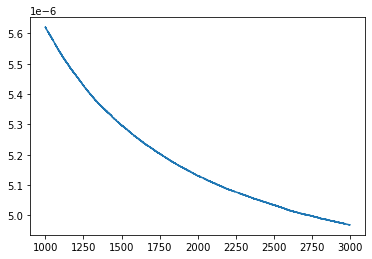

In [39]:
plt.plot(time[1000000:time.shape[0]],Opt_cost[1000000:time.shape[0]])

In [57]:
new_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    new_regret[t]=cost[t]-Der_Exp_Opt_Cost                  
    #avg_regret[t]*=(t+1)

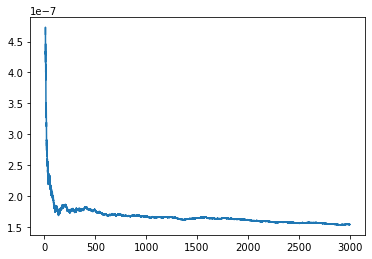

In [58]:
plt.plot(time[10000:3000000],new_regret[10000:3000000])

In [42]:
adhoc_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    adhoc_regret[t]=cost[t]-var1*np.trace(P1[0])
    #avg_regret[t]*=(t+1)

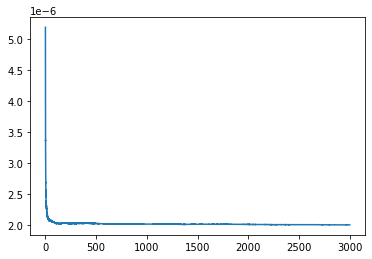

In [43]:
plt.plot(time[1000:3000000],adhoc_regret[1000:3000000])

In [44]:
adhoc_regret2=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    adhoc_regret2[t]=cost[t]-var2*np.trace(P2[0])
    #avg_regret[t]*=(t+1)

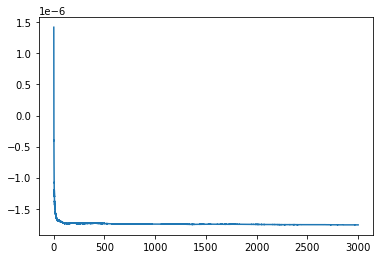

In [45]:
plt.plot(time[1000:3000000],adhoc_regret2[1000:3000000])

In [46]:
emp_regret=np.zeros((time.shape[0]))
for t in range((time.shape[0])):
    emp_regret[t]=cost[t]-Opt_cost[t]
    #avg_regret[t]*=(t+1)

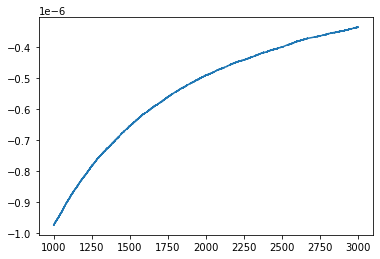

In [47]:
plt.plot(time[1000000:time.shape[0]],emp_regret[1000000:time.shape[0]])

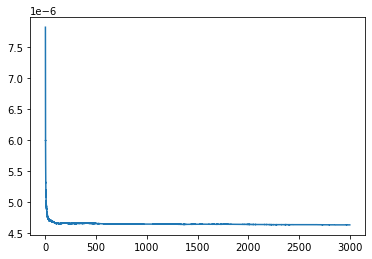

In [71]:
plt.plot(time[1000:3000000],cost[1000:3000000])

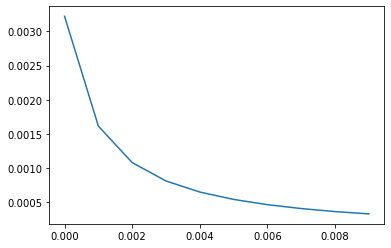

In [49]:
plt.plot(time[0:10],cost[0:10])

In [50]:
Opt_Final_Cost

4.9683381685166536e-06

In [69]:
#Sample Static Policy Run


K=0.1*np.random.rand(2,2)


Sample_x_dynamics=np.zeros((2,time.shape[0]))
Sample_x_0=np.random.rand(2)
Sample_x_dynamics[:,0]=Opt_x_0
Sample_x_dynamics
Sample_cost=np.zeros((time.shape[0]))
Sample_cost_agg=np.zeros((time.shape[0]))
Sample_x_norm=np.zeros((time.shape[0]))









markov_state=0
Sample_ms=np.zeros((time.shape[0]))
Sample_ms[0]=0

Sample_u_0= K.dot(Opt_x_0)

Sample_c_0=Sample_x_0.dot((Q.dot(Sample_x_0)))+Sample_u_0.dot((R.dot(Sample_u_0)))

Sample_cost[0]=Sample_c_0
Sample_cost_agg[0]=Sample_c_0
Sample_x_norm[0]=LA.norm(Sample_x_0,2)

#Now we simulate the Markov Jump Dynamical System, this time playing optimally using Riccati Policies

for t in range(1,time.shape[0]):
    xprev=Sample_x_dynamics[:,t-1]
    markov_state=Sample_ms[t-1]
    if (markov_state==0):
        uprev=K.dot(xprev)
        markov_state=np.random.choice(2,1,p=[p,1-p])
    else:
        uprev=K.dot(xprev)
        markov_state=np.random.choice(2,1,p=[1-q,q])    
    if (markov_state==0):
        xt=A1.dot(xprev)+B1.dot(uprev)+np.random.normal(0,np.sqrt(var1),xprev.shape)
        ut=K.dot(xt)
    else:
        xt=A2.dot(xprev)+B2.dot(uprev)+np.random.normal(0,np.sqrt(var2),xprev.shape)
        ut=K.dot(xt)
    nct=xt.dot(Q.dot(xt))+ut.dot(R.dot(ut))
    c=(Sample_cost[t-1]*(t)+nct)/(t+1)
    Sample_x_norm[t]=LA.norm(xt,2)
    Sample_cost[t]=c
    Sample_cost_agg[t]=Sample_cost_agg[t-1]+nct
    Sample_ms[t]=markov_state
    Sample_x_dynamics[:,t]=xt

Sample_Final_Cost=(Sample_cost[time.shape[0]-1]*(time.shape[0])+Sample_x_dynamics[:,time.shape[0]-1].dot(Q.dot(Sample_x_dynamics[:,time.shape[0]-1])))/(time.shape[0]+1)

Sample_Final_Cost_agg=Sample_Final_Cost*(time.shape[0]+1)


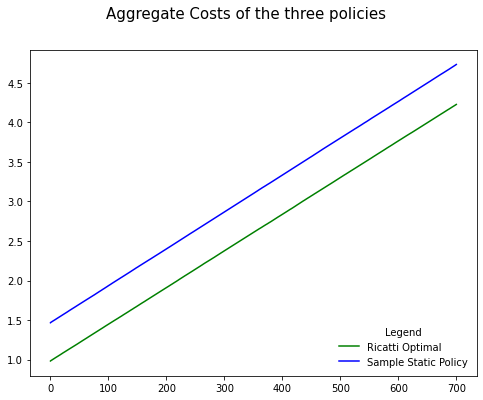

In [70]:
# Initialise the figure and axes.
fig, ax = plt.subplots(1, figsize=(8, 6))


# Set the title for the figure
fig.suptitle('Aggregate Costs of the three policies', fontsize=15)

# Draw all the lines in the same plot, assigning a label for each one to be
# shown in the legend.
#ax.plot(time[0:700000], agg_cost_dynamics[0:700000], color="red", label="Modified OSLO")
ax.plot(time[0:700000], Opt_cost_agg[0:700000], color="green", label="Ricatti Optimal")
ax.plot(time[0:700000], Sample_cost_agg[0:700000], color="blue", label="Sample Static Policy")
#ax.plot(time, agg_regret, color="red", label="Sum Regret")
#ax.plot(time, avg_regret,color="black", label="Average Regret")
# Add a legend, and position it on the lower right (with no box)
plt.legend(loc="lower right", title="Legend", frameon=False)

plt.show()


In [53]:
#Testing convergence of policy learnt against the DP policy:
#print(LA.norm((Augmented-AtBt),'fro'))
Policy_err=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    if (ms[t]==0):
        Policy_err[t]=LA.norm((K_dynamicsa[t]+K1[t]),'fro')
    else:
        Policy_err[t]=LA.norm((K_dynamicsb[t]+K2[t]),'fro')
#plt.plot(time[10:100],Policy_err[10:100])

In [54]:
#plt.plot(time[10:100],Policy_err[10:100])

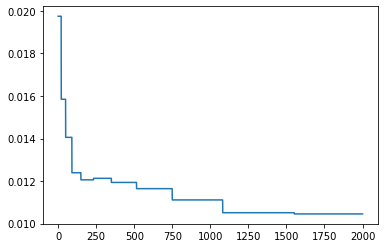

In [55]:
#Testing convergence of policy learnt against the DP policy for mode a:
#print(LA.norm((Augmented-AtBt),'fro'))
Policy_err_a=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    Policy_err_a[t]=LA.norm((K_dynamicsa[t]+K1[t]),'fro')
   
        
plt.plot(time[0:2000000],Policy_err_a[0:2000000])

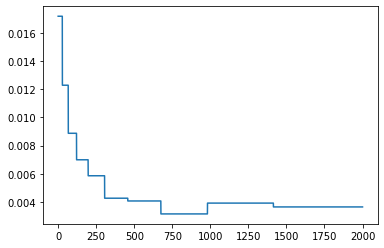

In [56]:
#Testing convergence of policy learnt against the DP policy for mode b:
#print(LA.norm((Augmented-AtBt),'fro'))
Policy_err_b=np.zeros((time.shape[0]))
for t in range(time.shape[0]):
    Policy_err_b[t]=LA.norm((K_dynamicsb[t]+K2[t]),'fro')
   
        
plt.plot(time[0:2000000],Policy_err_b[0:2000000])